# Developing an AI application

In this project, I have trained an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

Following is link to our dataset: [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz)

In [1]:
# Imports here
>>> import sys
>>> sys.modules[__name__].__dict__.clear()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import helper

## Load the data

Here I shall use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into three parts, training, validation, and testing. For the training, I will apply transformations such as random scaling, cropping, and flipping. This will help the network generalize, leading to better performance. I shall also resize the input data to 224x224 pixels as required by the pre-trained networks.

The pre-trained networks are trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I will need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
val_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

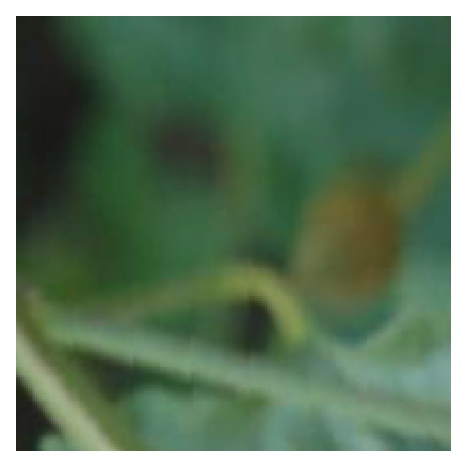

In [3]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
val_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform=test_transforms)
val_datasets = datasets.ImageFolder(val_dir, transform=val_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_datasets, batch_size = 64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_datasets, batch_size = 64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size = 64, shuffle=True)

# print(summary(trainloaders))
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

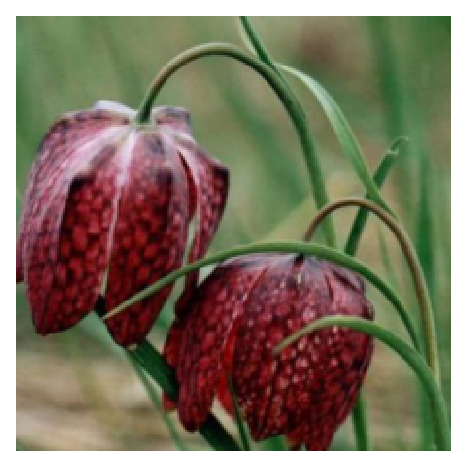

In [4]:
# Printing an image out to see if data is available in my validation set
image, label = next(iter(valloader))
helper.imshow(image[0,:]);

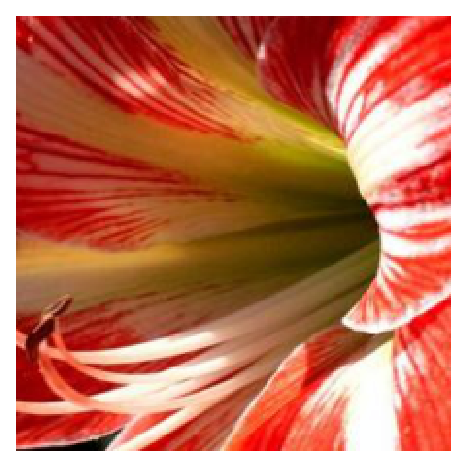

In [5]:
# Printing an image out to see if data is available in my test set
image, label = next(iter(testloader))
helper.imshow(image[0,:]);

### Label mapping

The mapping from category label to category name can be found in file 'cat_to_name.json`.

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

I shall use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

When training, we must be carefull as to update only the weights of the feed-forward network. 

In [7]:
# Build and train your network
model = models.densenet121(pretrained=True)
print(model)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 90078700.78it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [8]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(nn.Linear(1024, 1000),
                           nn.Dropout(p=0.2),
                           nn.ReLU(),
                           nn.Linear(1000, 500),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(500,102),
                           nn.LogSoftmax(dim=1))
model.classifier= classifier

In [9]:
# Only train the classifier parameters, feature parameters are frozen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 3
steps = 0
running_loss = 0
print_every = 10

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            val_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in valloader:
                 
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    val_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                             
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"val loss: {val_loss/len(valloader):.3f}.. "
                  f"val accuracy: {accuracy/len(valloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/3.. Train loss: 4.577.. val loss: 4.454.. val accuracy: 0.051
Epoch 1/3.. Train loss: 4.382.. val loss: 4.271.. val accuracy: 0.055
Epoch 1/3.. Train loss: 4.127.. val loss: 3.934.. val accuracy: 0.144
Epoch 1/3.. Train loss: 3.772.. val loss: 3.485.. val accuracy: 0.228
Epoch 1/3.. Train loss: 3.397.. val loss: 3.111.. val accuracy: 0.301
Epoch 1/3.. Train loss: 3.030.. val loss: 2.624.. val accuracy: 0.348
Epoch 1/3.. Train loss: 2.751.. val loss: 2.445.. val accuracy: 0.431
Epoch 1/3.. Train loss: 2.462.. val loss: 2.143.. val accuracy: 0.469
Epoch 1/3.. Train loss: 2.312.. val loss: 1.966.. val accuracy: 0.531
Epoch 1/3.. Train loss: 2.076.. val loss: 1.733.. val accuracy: 0.587
Epoch 2/3.. Train loss: 1.836.. val loss: 1.596.. val accuracy: 0.580
Epoch 2/3.. Train loss: 1.741.. val loss: 1.579.. val accuracy: 0.595
Epoch 2/3.. Train loss: 1.585.. val loss: 1.372.. val accuracy: 0.648
Epoch 2/3.. Train loss: 1.567.. val loss: 1.434.. val accuracy: 0.646
Epoch 2/3.. Train lo

## Testing your network

It's good practice to test a trained network on test data, images the network has never seen either in training or validation. This will give me a good estimate for the model's performance on completely new images.

In [10]:
# Do validation on the test set
test_loss = 0
accuracy = 0
model.to('cuda')
# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    model.eval()
    for images, labels in testloader:
        images, labels = images.to('cuda'), labels.to('cuda')
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Accuracy: 0.756


## Save the checkpoint

Now I must save our trained model so you can load it later for making predictions. One must follow this practice as to make sure that everytime when he/she have to use it, there should not be a neccessity to train it first and then get predictions.

In [11]:
# TODO: Save the checkpoint 
checkpoint = {'input_size': 1024,
              'output_size': 102,
              'classifier': classifier,
              'state_dict': model.state_dict(),
             'class_to_idx': train_datasets.class_to_idx,
             'arch': 'densenet121',
             'learning_rate': 0.001,
             'epochs': epochs,
             'optimizer':  optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [12]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    learning_rate = checkpoint['learning_rate']
    model.epochs = checkpoint['epochs']
    model.optimizer = checkpoint['optimizer']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

load_checkpoint('checkpoint.pth')  
print(model)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

# Inference for classification

Now I must write a function to use a trained network for inference. That is, I shall pass an image into the network and predict the class of the flower in the image. I will write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. But we would need to process our image first to make it suitable to be fed to our network.

## Image Preprocessing

I will use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

In [13]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    size = [0, 0]

    if image.size[0] > image.size[1]:
        size = [image.size[0], 256]
    else:
        size = [256, image.size[1]]
    
    image.thumbnail(size, Image.ANTIALIAS)    
    w, h = image.size  

    l = (256 - 224)/2
    t = (256 - 224)/2
    r = (256 + 224)/2
    b = (256 + 224)/2

    image = image.crop((l, t, r, b))
    image = np.array(image)
    image = image/255.
                       
    mean = np.array([0.485, 0.456, 0.406])
    sd = np.array([0.229, 0.224, 0.225])                       
    image = ((image - mean) / sd)    
    image = np.transpose(image, (2, 0, 1))
    
    return image

To check my work, the function below converts a PyTorch tensor and displays it in the notebook. 

In [14]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

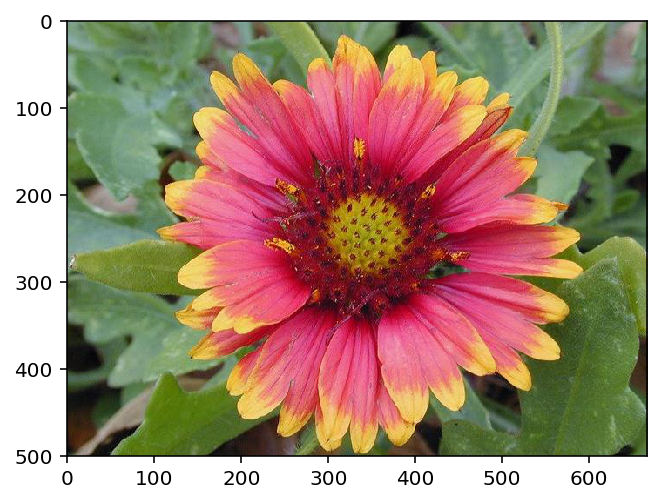

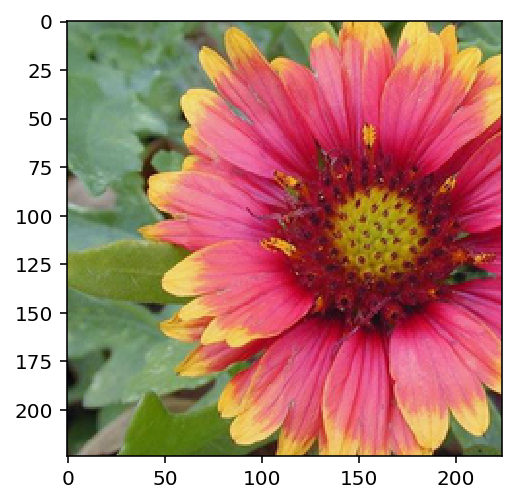

In [15]:
img_path = 'flowers/test/100/image_07897.jpg'

with Image.open(img_path) as image: # original
    plt.imshow(image)
    
with Image.open(img_path) as image: #processed with functions
    imshow(process_image(image))

## Class Prediction

After getting images in correct format, it's time to write a function for making predictions with my model. I shall predict the top 5 most probable classes. I shall calculate the class probabilities and find largest value from all.

To get the top $K$ largest values in a tensor I will use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. 

In [16]:
model.class_to_idx = train_datasets.class_to_idx # 0 = train

ctx = model.class_to_idx

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    model.to('cuda')
    
    img_torch = Image.open(image_path) # process the image, from reviewer advice
    img_torch = process_image(img_torch)
    img_torch = torch.from_numpy(img_torch)
    
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda()) # use cuda
        
    probability = F.softmax(output.data,dim=1) # use F
    
    probs = np.array(probability.topk(topk)[0][0])
    
    index_to_class = {val: key for key, val in model.class_to_idx.items()} # from reviewer advice
    top_classes = [np.int(index_to_class[each]) for each in np.array(probability.topk(topk)[1][0])]
    
    return probs, top_classes

In [17]:
# sanity check
img = ('flowers/test/1/image_06743.jpg') # should be primrose, class = 1
probs, classes = predict(img, model)
print(probs)
print(classes)

[ 0.95867449  0.01132876  0.00931506  0.00459764  0.0041292 ]
[1, 51, 86, 70, 76]


## Sanity Checking

Now that I can use a trained model for predictions, I shall check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. I will use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. 

I can convert from the class integer encoding to actual flower names with the `cat_to_name.json`.

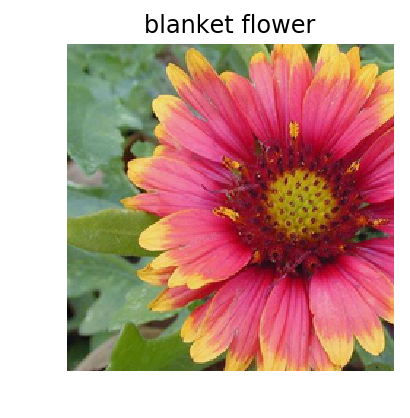

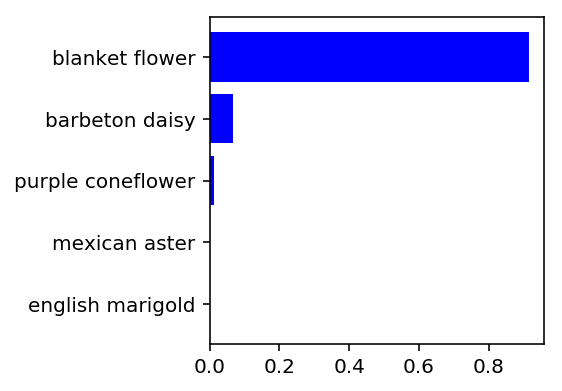

In [21]:
# Display an image along with the top 5 classes
plt.figure(figsize=(3,3))
# plt.subplot(211)
    
path = ('flowers/test/100/image_07897.jpg') # pink primrose test
    
probs, classes = predict(path, model)
image = process_image(Image.open(path)) # need to open with PIL first
max_index = classes[0]
    
axs = imshow(image, ax = plt)
axs.axis('off')
axs.title(cat_to_name[str(max_index)])
axs.show()

# following graph is adapted from https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
plt.figure(figsize=(3,3))
# plt.subplot(212)

names = [cat_to_name[str(index)] for index in classes]
y_pos = np.arange(len(names))
performance = np.array(probs)

plt.barh(y_pos, performance, align='center',
        color='blue')
plt.yticks(y_pos, names)
plt.gca().invert_yaxis()  # labels read top-to-bottom